• Cálculo da curvatura ao longo do contorno de objetos
• Utilizar a fórmula da curvatura apresentada nos slides acima
• Note que um valor de curvatura é calculado para cada ponto do contorno
• Identificar picos positivos e negativos de curvatura
• É recomendado que a curvatura seja suavizada para identificação dos picos
• Definir 5 propriedades para caracterizar objetos a partir da curvatura (valor máximo, etc)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def image_contour(img):
    '''Obtém o contorno paramétrico de um objeto contido
       no array img.'''
    
    # Mapeamento utilizado para encontrar o vizinho inicial a ser
    # buscado na próxima iteração dado o vizinho do ponto atual
    # Por exemplo, se o ponto atual for (12, 15) e o próximo ponto
    # de borda for (12, 16), isso significa que o vizinho de índice
    # 2 será o próximo ponto de borda. Nesse novo ponto, precisamos
    # buscar a partir do vizinho de índice 1, pois o vizinho de
    # índice 0 foi o último ponto a ser verificado antes de encontrarmos
    # o ponto atual
    neighbor_map = [7, 7, 1, 1, 3, 3, 5, 5]
    
    # Adiciona 0 ao redor da imagem para evitar pontos 
    # do objeto tocando a borda
    img_pad = np.pad(img, 1, mode='constant')
    
    num_rows, num_cols = img_pad.shape
    k = 0
    row = 0
    col = 0
    # Busca do primeiro ponto do objeto
    while img_pad[row, col]==0:
        k += 1
        row = k//num_cols
        col = k - row*num_cols
        
    curr_point = (row, col)    # Ponto atual
    contour = [curr_point]     # Pontos do contorno
    starting_index = 2         # Índice do vizinho inicial a ser verificado
    while True:
        next_point, last_index = get_next_point(img_pad, curr_point, 
                                                    starting_index)

        # Novo índice do vizinho inicial baseado no último
        # índice buscado
        starting_index = neighbor_map[last_index]
        
        # Critério de parada. Se o ponto adicionado na iteração anterior (contour[-1])
        # for o mesmo que o primeiro ponto (contour[0]) e o ponto atual for o mesmo
        # que o segundo ponto adicionado, o algoritmo termina. Só podemos fazer essa
        # verificação se o contorno possuir ao menos 2 pontos. Ou seja, nosso algoritmo
        # não está tratando o caso de um objeto com apenas 1 pixel
        if len(contour)>1:
            if next_point==contour[1] and contour[-1]==contour[0]:
                break
                
        contour.append(next_point)
        curr_point = next_point
        
    # Subtrai 1 de cada ponto pois o contorno foi encontrado para a
    # imagem preenchida com 0 na borda
    for point_index, point in enumerate(contour):
        contour[point_index] = (point[0]-1, point[1]-1)
        
    return contour

def get_next_point(img, curr_point, starting_index):
    '''Encontra o próximo ponto de borda dado um ponto
       corrente curr_point e o índice do primeiro vizinho
       a ser verificado (starting_index)'''
     
    # Lista dos pontos vizinhos dado o índice do vizinho
    nei_list = [(-1,0), (-1,1), (0,1), (1,1), 
                (1,0), (1,-1),(0,-1), (-1,-1)]
    
    curr_index = starting_index
    nei_value = 0
    while nei_value==0:
        nei_shift = nei_list[curr_index]
        nei_row = curr_point[0] + nei_shift[0]
        nei_col = curr_point[1] + nei_shift[1]
        nei_value = img[nei_row, nei_col]
        if nei_value==1:
            return (nei_row, nei_col), curr_index
        else:
            curr_index = (curr_index+1)%8

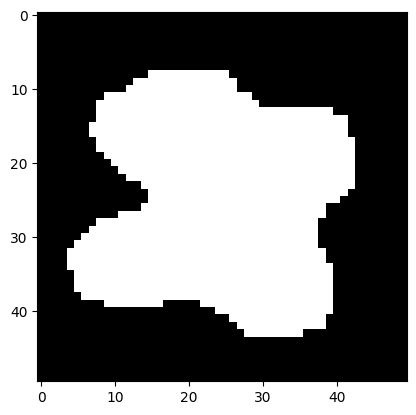

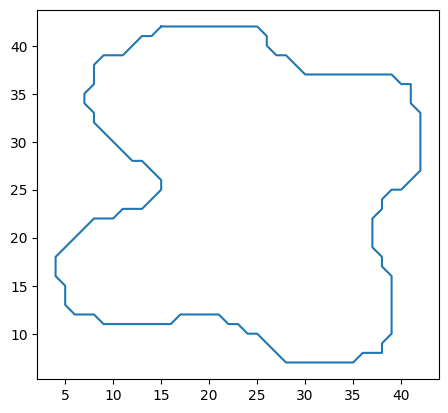

In [2]:
img = plt.imread('blob.tiff')
img = img>0
plt.imshow(img, 'gray')

cont = image_contour(img)
# Transforma o contorno em um array numpy
cont = np.array(cont)

plt.figure()
plt.subplot(111, aspect='equal')
# Plota os pontos de contorno, precisamos inverter os valores em y porque,
# na imagem, a origem está no ponto superior esquerdo
plt.plot(cont[:,1], img.shape[0]-cont[:,0])

In [3]:
def curvature(contour):
    n = len(contour)
    curvature = np.zeros(n)
    for i in range(1, n-1):
        x_i, y_i = contour[i]
        x_im1, y_im1 = contour[i-1]
        x_ip1, y_ip1 = contour[i+1]
        num = 2*(y_im1 - 2*y_i + y_ip1)**2 + 2*(x_im1 - 2*x_i + x_ip1)**2
        den = ( (x_im1-x_ip1)**2 + (y_im1-y_ip1)**2 )**(3/2)
        curvature[i] = num / den
    return curvature

In [4]:
def smooth_curvature(curvature, k=5):
    '''Suaviza a curvatura utilizando um filtro de média móvel com tamanho k.'''
    suavizada = np.convolve(curvature, np.ones(k)/k, mode='same')
    return suavizada


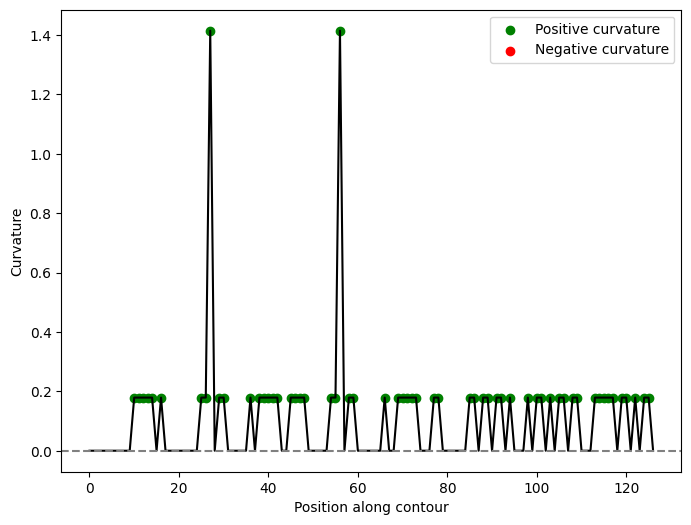

In [5]:
curv = curvature(cont)
sign = np.sign(curv)
pos = np.where(sign == 1)[0]
neg = np.where(sign == -1)[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(curv, color='black')
ax.scatter(pos, curv[pos], color='green', label='Positive curvature')
ax.scatter(neg, curv[neg], color='red', label='Negative curvature')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Position along contour')
ax.set_ylabel('Curvature')
ax.legend()
plt.show()

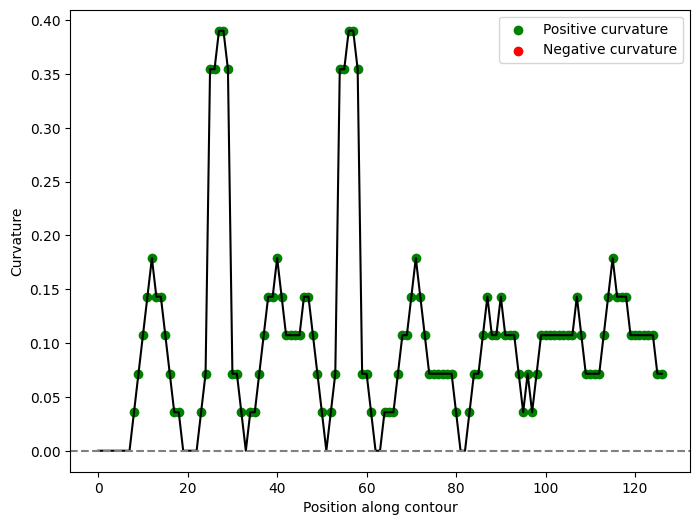

[  8   9  10  11  12  13  14  15  16  17  18  23  24  25  26  27  28  29
  30  31  32  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  52  53  54  55  56  57  58  59  60  61  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
[]


In [22]:
suav = smooth_curvature(curv, k =5)

sign = np.sign(suav)
pos = np.where(sign == 1)[0]
neg = np.where(sign == -1)[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(suav, color='black')
ax.scatter(pos, suav[pos], color='green', label='Positive curvature')
ax.scatter(neg, suav[neg], color='red', label='Negative curvature')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Position along contour')
ax.set_ylabel('Curvature')
ax.legend()
plt.show()

print(pos)
print(neg)

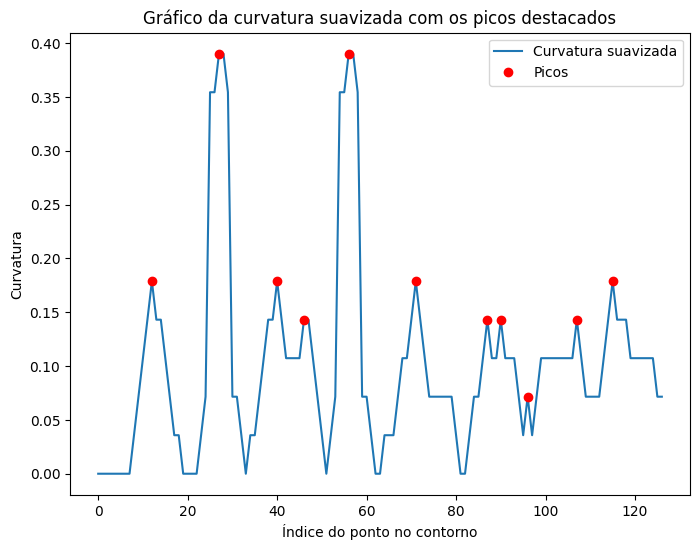

In [7]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Suponha que a curvatura suavizada foi calculada e armazenada na lista 'curvatura_suavizada'
# Suponha também que o array do contorno do objeto foi armazenado na lista 'contorno'

# Encontra os índices dos picos na curvatura suavizada
picos, _ = find_peaks(suav)

# Gera o gráfico da curvatura suavizada e dos picos
plt.figure(figsize=(8,6))
plt.plot(suav, label='Curvatura suavizada')
plt.plot(picos, suav[picos], 'ro', label='Picos')
plt.xlabel('Índice do ponto no contorno')
plt.ylabel('Curvatura')
plt.title('Gráfico da curvatura suavizada com os picos destacados')
plt.legend()
plt.show()

### Propriedas para caracterizar o objeto

In [23]:
#Excentricidade

# Calcula a curvatura média
curvatura_media = np.mean(curv)

# Calcula a curvatura máxima e mínima
curvatura_maxima = np.max(curv)
curvatura_minima = np.min(curv)

# Calcula os raios maior e menor
a = 1 / curvatura_minima
b = 1 / curvatura_maxima

# Calcula a excentricidade
excentricidade = (a - b) / a

print("Excentricidade:", excentricidade)

Excentricidade: nan


/tmp/ipykernel_1328/730425768.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  a = 1 / curvatura_minima
/tmp/ipykernel_1328/730425768.py:15: RuntimeWarning: invalid value encountered in double_scalars
  excentricidade = (a - b) / a


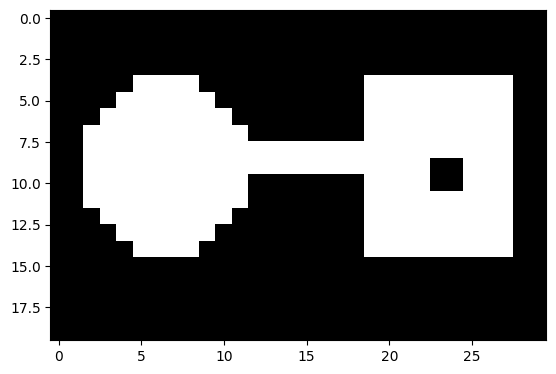

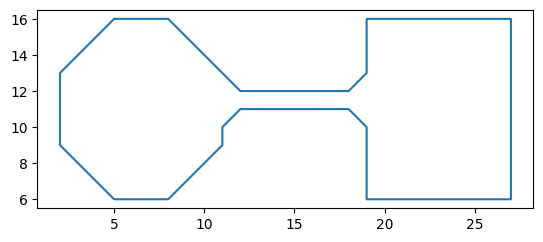

In [8]:
img = plt.imread('shape.tiff')
img = img>0
plt.imshow(img, 'gray')

cont = image_contour(img)
# Transforma o contorno em um array numpy
cont = np.array(cont)

plt.figure()
plt.subplot(111, aspect='equal')
# Plota os pontos de contorno, precisamos inverter os valores em y porque,
# na imagem, a origem está no ponto superior esquerdo
plt.plot(cont[:,1], img.shape[0]-cont[:,0])

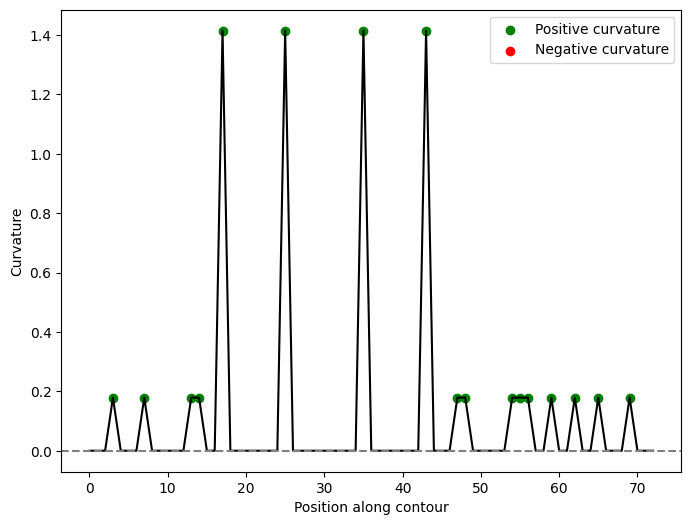

In [9]:
curv2 = curvature(cont)
sign = np.sign(curv2)
pos = np.where(sign == 1)[0]
neg = np.where(sign == -1)[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(curv2, color='black')
ax.scatter(pos, curv2[pos], color='green', label='Positive curvature')
ax.scatter(neg, curv2[neg], color='red', label='Negative curvature')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Position along contour')
ax.set_ylabel('Curvature')
ax.legend()
plt.show()

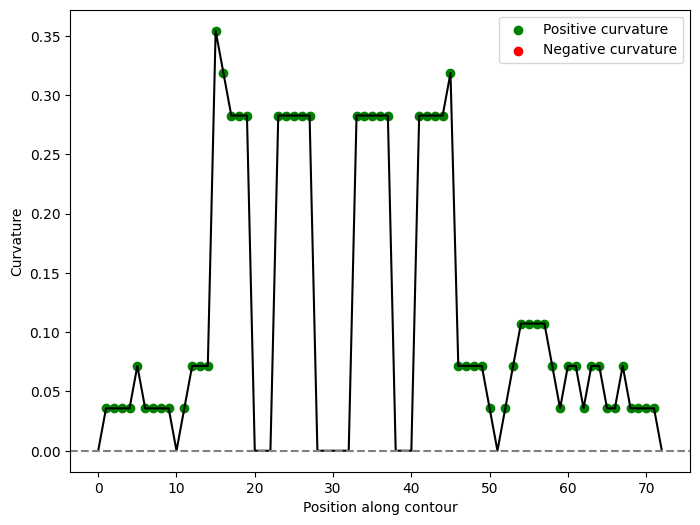

In [10]:
suav2 = smooth_curvature(curv2, k =5)

sign = np.sign(suav2)
pos = np.where(sign == 1)[0]
neg = np.where(sign == -1)[0]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(suav2, color='black')
ax.scatter(pos, suav2[pos], color='green', label='Positive curvature')
ax.scatter(neg, suav2[neg], color='red', label='Negative curvature')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Position along contour')
ax.set_ylabel('Curvature')
ax.legend()
plt.show()